In [1]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Loading Data and Models

#### Loading Data

In [2]:
filepath = '../../split_year_data'

In [3]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [5]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [6]:
with open('../../split_year_data/countries_dict.pkl', 'rb') as f:
    countries_dict = pickle.load(f)


In [7]:
train_val = pd.read_csv('../../split_year_data/train_val.csv')
train_val = train_val.drop(columns=['Unnamed: 0'], axis=1)
train_val_input = train_val.drop(columns=['Maternal mortality ratio (national estimate, per 100,000 live births)'], axis=1)
train_val_label = train_val['Maternal mortality ratio (national estimate, per 100,000 live births)']

#### Loading Models

Just using the Random Forest and LightGBM models trained on the full dataset and dataset with a missing data threshold of 95% because XGBoost models and all models trained on dataset with 85% threshold had lower performance across all metrics.  

In [8]:
lgbm_models = []
rf_models = []

In [9]:
lgbm_col_needed = []
rf_col_needed = []

In [10]:
output_dir = '../../split_year_models'

##### Training the models on their best hyperparameters and storing them in lists

In [11]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 1:
            continue

        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/lightgbm/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        lgbm_col_needed.append(train_input_data.columns.tolist())

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        lgbm_models.append(train_load)        

In [12]:
for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

        if thresh == 1:
            continue
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/random_forest/best_params_{fold}_{name}.pkl")
        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)
        train_label = train[fold][thresh * 2 + 1].copy()
        rf_col_needed.append(train_input_data.columns.tolist())

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train_label)
        rf_models.append(train_load)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

In [13]:
len(rf_models), len(lgbm_models)

(10, 10)

### Loading Model Predictions

In [14]:
#combine models into a single list of base estimators
base_estimators = lgbm_models + rf_models
(base_estimators)

[LGBMRegressor(bagging_fraction=0.46422916813430687, bagging_freq=2,
               boosting_type='dart', l1_norm=4.4852748600985146e-05,
               l2_norm=0.00019727191645972726, learning_rate=0.0841403960017377,
               max_tree_depth=21, number_trees=252, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.5310090771576965, bagging_freq=6,
               boosting_type='dart', l1_norm=0.0007074939068738357,
               l2_norm=4.9620295490784465e-05, learning_rate=0.11041661896818841,
               max_tree_depth=24, number_trees=282, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.61489782009405, bagging_freq=3,
               boosting_type='dart', l1_norm=0.0005707417481197812,
               l2_norm=0.00045912693969249804, learning_rate=0.16789852752946396,
               max_tree_depth=22, number_trees=39, verbosity=-1),
 LGBMRegressor(bagging_fraction=0.25798883959105195, bagging_freq=1,
               boosting_type='dart', l1_norm=5.182615080547187e-05,
          

In [15]:
train_val_input['setting'] = train_val_input['setting'].astype("category")

In [16]:
predictions = []

for idx, model in enumerate(base_estimators):
        if idx < 10:
            train_val_input_subset = train_val_input.copy()
            train_val_input_subset.columns = train_val_input_subset.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            train_val_input_subset = train_val_input_subset[lgbm_col_needed[idx]]
            
        else:
            train_val_input_relevant = train_val_input[rf_col_needed[idx - 10]]
            train_val_input_subset = train_val_input_relevant.copy()
            train_val_input_subset['setting'] = train_val_input_subset['setting'].map(countries_dict)

        predictions.append(model.predict(train_val_input_subset))

stacked_predictions = np.column_stack(predictions)

In [17]:
from sklearn.model_selection import train_test_split

X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    stacked_predictions, train_val_label, test_size=0.2, random_state=42
)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_meta_train_scaled = scaler.fit_transform(X_meta_train)
X_meta_val_scaled = scaler.transform(X_meta_val)

In [19]:
target_scaler = StandardScaler()
y_meta_train_scaled = target_scaler.fit_transform(np.array(y_meta_train).reshape(-1, 1)).ravel()
y_meta_val_scaled = target_scaler.transform(np.array(y_meta_val).reshape(-1, 1)).ravel()

### Voting Ensemble

Want to finetune the weights given to each of the base models in the voting ensemble model.

In [20]:
def voting_objective(trial):

    weights = []
    for i in range(20):
        weights.append(trial.suggest_float("weights_" + str(i), 0.0, 1.0))

    w_sum = sum(weights)
    w_normalised = [w / w_sum for w in weights]

    weighted_predictions = np.dot(stacked_predictions, w_normalised)

    return mean_squared_error(train_val_label, weighted_predictions)

In [21]:
#Create a study object and optimize the objective function.
voting_study = optuna.create_study(direction='minimize')
voting_study.optimize(voting_objective, n_trials=300)

[I 2025-08-01 08:05:22,694] A new study created in memory with name: no-name-ad32ffe7-d331-453e-8857-414aa53f1ae5
[I 2025-08-01 08:05:22,709] Trial 0 finished with value: 2800.235415875602 and parameters: {'weights_0': 0.7779705994884244, 'weights_1': 0.1090569528183204, 'weights_2': 0.1176980737784421, 'weights_3': 0.4916437769060842, 'weights_4': 0.4634521869023104, 'weights_5': 0.6986082211091447, 'weights_6': 0.23278863415586692, 'weights_7': 0.901015038320828, 'weights_8': 0.2011353147583852, 'weights_9': 0.874044275065608, 'weights_10': 0.3105758654963994, 'weights_11': 0.5160852749719109, 'weights_12': 0.7774008920612505, 'weights_13': 0.9786957251213666, 'weights_14': 0.04817220316743753, 'weights_15': 0.16850239126906508, 'weights_16': 0.06134063801663958, 'weights_17': 0.2230452498414437, 'weights_18': 0.8464624181558037, 'weights_19': 0.649141040064727}. Best is trial 0 with value: 2800.235415875602.
[I 2025-08-01 08:05:22,727] Trial 1 finished with value: 3021.148042677537 

In [22]:
joblib.dump(voting_study.best_params, f"../../split_year_models/ensemble/voting_best_params.pkl")
joblib.dump(voting_study, f"../../split_year_models/ensemble/voting_optuna_study.pkl")

['../../split_year_models/ensemble/voting_optuna_study.pkl']

In [23]:
bp = voting_study.best_params
normalised_bp = {k: v / sum(bp.values()) for k, v in bp.items()}
normalised_bp

{'weights_0': 0.01140283808613561,
 'weights_1': 0.030159135816254498,
 'weights_2': 0.03468906300086026,
 'weights_3': 0.012070612778268649,
 'weights_4': 0.13594098207864408,
 'weights_5': 0.10527652875091603,
 'weights_6': 0.0035850860903886414,
 'weights_7': 0.14987048932516597,
 'weights_8': 0.004447841496785966,
 'weights_9': 0.08520005964975735,
 'weights_10': 0.004380187689841886,
 'weights_11': 0.08345502717020692,
 'weights_12': 0.02319709855886547,
 'weights_13': 0.011722395444655878,
 'weights_14': 0.013294383068722269,
 'weights_15': 0.033538468641787444,
 'weights_16': 0.0006895378199669675,
 'weights_17': 0.10585009494220626,
 'weights_18': 0.0082703647756065,
 'weights_19': 0.14295980481496337}

In [24]:
joblib.dump(normalised_bp, f"../../split_year_models/ensemble/voting_normalised_best_params.pkl")

['../../split_year_models/ensemble/voting_normalised_best_params.pkl']

### Stacking Ensemble

#### Linear Regression -> Elastic Net

In [25]:
def stacked_objective_linreg(trial):

    alpha = trial.suggest_float("alpha", 0.1, 1.0)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    
    #to get the predictions of the base models 
    #fit_intercept=True
    elastic_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, random_state=42)
    elastic_model.fit(X_meta_train, y_meta_train)
    elastic_predictions = elastic_model.predict(X_meta_val)

    return mean_squared_error(y_meta_val, elastic_predictions)

In [26]:
#Create a study object and optimize the objective function.
linreg_stacking_study = optuna.create_study(direction='minimize')
linreg_stacking_study.optimize(stacked_objective_linreg, n_trials=300)

[I 2025-08-01 08:06:01,734] A new study created in memory with name: no-name-25313670-d044-41cc-bcc9-783a90bc1aba
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.794e+05, tolerance: 5.877e+03
  model = cd_fast.enet_coordinate_descent(
[I 2025-08-01 08:06:01,985] Trial 0 finished with value: 467.2018752397538 and parameters: {'alpha': 0.5378771604387992, 'l1_ratio': 0.8701990447549647}. Best is trial 0 with value: 467.2018752397538.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.846e+05, tolerance: 5.877e+03
  model = cd_fast.enet

In [27]:
linreg_stacking_study.best_params

{'alpha': 0.10014764345653215, 'l1_ratio': 0.0005017516169458121}

In [28]:
joblib.dump(linreg_stacking_study.best_params, f"../../split_year_models/ensemble/linreg_stacking_best_params.pkl")
joblib.dump(linreg_stacking_study, f"../../split_year_models/ensemble/linreg_stacking_optuna_study.pkl")

['../../split_year_models/ensemble/linreg_stacking_optuna_study.pkl']

In [29]:
best_linreg_model = ElasticNet(**linreg_stacking_study.best_params)
best_linreg_model.fit(stacked_predictions, train_val_label)
joblib.dump(best_linreg_model, "../../split_year_models/ensemble/linreg_stacking_best_model.pkl")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.922e+05, tolerance: 7.040e+03
  model = cd_fast.enet_coordinate_descent(


['../../split_year_models/ensemble/linreg_stacking_best_model.pkl']

#### Random Forest

In [30]:
def stacked_objective_rf(trial):

    n_trees = trial.suggest_int("n_estimators", 10, 300)

    max_depth = trial.suggest_int("max_depth", 3, 25)

    min_sample_split = trial.suggest_int("min_samples_split", 2, 10)

    bootstrapping = trial.suggest_categorical("bootstrap", [True, False])
    if bootstrapping == False:
        max_samples = None
    else:
        max_samples = trial.suggest_float("max_samples", 0.01, 1.0)

    rf = RandomForestRegressor(random_state=42, min_samples_split=min_sample_split, bootstrap=bootstrapping, max_samples=max_samples, n_estimators=n_trees, max_depth=max_depth)
    
    rf.fit(X_meta_train, y_meta_train)
    rf_predictions = rf.predict(X_meta_val)

    return mean_squared_error(y_meta_val, rf_predictions)

In [31]:
#Create a study object and optimize the objective function.
rf_stacking_study = optuna.create_study(direction='minimize')
rf_stacking_study.optimize(stacked_objective_rf, n_trials=300)

[I 2025-08-01 08:06:48,766] A new study created in memory with name: no-name-fce37c69-94fc-40c1-9cc0-44e194b2fbd1
[I 2025-08-01 08:06:49,403] Trial 0 finished with value: 1280.3705010761005 and parameters: {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 4, 'bootstrap': True, 'max_samples': 0.40225765024624605}. Best is trial 0 with value: 1280.3705010761005.
[I 2025-08-01 08:06:49,924] Trial 1 finished with value: 1380.5477802778432 and parameters: {'n_estimators': 103, 'max_depth': 6, 'min_samples_split': 10, 'bootstrap': True, 'max_samples': 0.3246539847972197}. Best is trial 0 with value: 1280.3705010761005.
[I 2025-08-01 08:06:51,311] Trial 2 finished with value: 1192.0060581818439 and parameters: {'n_estimators': 243, 'max_depth': 5, 'min_samples_split': 3, 'bootstrap': True, 'max_samples': 0.40750863686001826}. Best is trial 2 with value: 1192.0060581818439.
[I 2025-08-01 08:06:55,762] Trial 3 finished with value: 1359.584784718719 and parameters: {'n_estimators': 123,

In [32]:
rf_stacking_study.best_params

{'n_estimators': 15,
 'max_depth': 19,
 'min_samples_split': 4,
 'bootstrap': True,
 'max_samples': 0.488176275277811}

In [33]:
joblib.dump(rf_stacking_study.best_params, f"../../split_year_models/ensemble/rf_stacking_best_params.pkl")
joblib.dump(rf_stacking_study, f"../../split_year_models/ensemble/rf_stacking_optuna_study.pkl")

['../../split_year_models/ensemble/rf_stacking_optuna_study.pkl']

In [34]:
best_rf_model = RandomForestRegressor(**rf_stacking_study.best_params)
best_rf_model.fit(stacked_predictions, train_val_label)
joblib.dump(best_rf_model, "../../split_year_models/ensemble/rf_stacking_best_model.pkl")

['../../split_year_models/ensemble/rf_stacking_best_model.pkl']

#### SVM

In [35]:
def stacked_objective_svm(trial):

    kernel = trial.suggest_categorical("kernel", ["poly", "rbf"])

    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)

    C = trial.suggest_float("C", 0.1, 1)
    epsilon = trial.suggest_float("epsilon", 0.05, 1.0)

    svm = SVR(kernel=kernel, degree=degree if kernel == "poly" else 0, C=C, epsilon=epsilon)
    
    svm.fit(X_meta_train, y_meta_train)
    svm_predictions = svm.predict(X_meta_val)

    return mean_squared_error(y_meta_val, svm_predictions)


In [36]:
#Create a study object and optimize the objective function.
svm_stacking_study = optuna.create_study(direction='minimize')
svm_stacking_study.optimize(stacked_objective_svm, n_trials=300)

[I 2025-08-01 08:10:03,775] A new study created in memory with name: no-name-8c2ae7fe-e940-4d21-bad1-8dd6555a2878
[I 2025-08-01 08:10:03,919] Trial 0 finished with value: 21104.521691472353 and parameters: {'kernel': 'rbf', 'C': 0.1899040434093136, 'epsilon': 0.4729479485751279}. Best is trial 0 with value: 21104.521691472353.
[I 2025-08-01 08:10:04,049] Trial 1 finished with value: 18068.731325418696 and parameters: {'kernel': 'rbf', 'C': 0.6618688263082609, 'epsilon': 0.9816005465902056}. Best is trial 1 with value: 18068.731325418696.
[I 2025-08-01 08:10:04,254] Trial 2 finished with value: 6505.28827556611 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 0.9514305168113537, 'epsilon': 0.5663679811837096}. Best is trial 2 with value: 6505.28827556611.
[I 2025-08-01 08:10:04,375] Trial 3 finished with value: 20035.00819242468 and parameters: {'kernel': 'rbf', 'C': 0.3291134246511636, 'epsilon': 0.5674350133408897}. Best is trial 2 with value: 6505.28827556611.
[I 2025-08-01 08:10

In [37]:
svm_stacking_study.best_params

{'kernel': 'poly',
 'degree': 2,
 'C': 0.9988224379377415,
 'epsilon': 0.9308536349035461}

In [38]:
joblib.dump(svm_stacking_study.best_params, f"../../split_year_models/ensemble/svm_stacking_best_params.pkl")
joblib.dump(svm_stacking_study, f"../../split_year_models/ensemble/svm_stacking_optuna_study.pkl")

['../../split_year_models/ensemble/svm_stacking_optuna_study.pkl']

In [39]:
best_svm_model = SVR(**svm_stacking_study.best_params)
best_svm_model.fit(stacked_predictions, train_val_label)
joblib.dump(best_svm_model, "../../split_year_models/ensemble/svm_stacking_best_model.pkl")

['../../split_year_models/ensemble/svm_stacking_best_model.pkl']

#### MLP

In [62]:
def stacked_objective_mlp(trial):

    n_layers = trial.suggest_int("n_layers", 2, 7)

    hidden_layer_sizes = []

    for i in range(n_layers):
        hidden_layer_sizes.append(trial.suggest_int("size_hidden_layer_" + str(i), 5, 150))
    
    activation = trial.suggest_categorical("activation", ["logistic", "relu"])

    alpha = trial.suggest_float("alpha", 0.001, 0.1)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])

    mlp = MLPRegressor(random_state=42, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver='adam', alpha=alpha, learning_rate=learning_rate)
    mlp.fit(X_meta_train_scaled, y_meta_train)
    mlp_predictions = mlp.predict(X_meta_val_scaled)

    return mean_squared_error(y_meta_val, mlp_predictions)



In [65]:
#Create a study object and optimize the objective function.
mlp_stacking_study = optuna.create_study(direction='minimize')
mlp_stacking_study.optimize(stacked_objective_mlp, n_trials=300)

[I 2025-08-01 09:38:56,679] A new study created in memory with name: no-name-b2e4c148-dcbb-4f87-8f4a-f3047d8019ef
[I 2025-08-01 09:39:00,540] Trial 0 finished with value: 568.519870984605 and parameters: {'n_layers': 7, 'size_hidden_layer_0': 45, 'size_hidden_layer_1': 90, 'size_hidden_layer_2': 147, 'size_hidden_layer_3': 38, 'size_hidden_layer_4': 35, 'size_hidden_layer_5': 45, 'size_hidden_layer_6': 11, 'activation': 'relu', 'alpha': 0.040685611924155825, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 568.519870984605.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-08-01 09:39:04,740] Trial 1 finished with value: 19145.492390541538 and parameters: {'n_layers': 3, 'size_hidden_layer_0': 144, 'size_hidden_layer_1': 23, 'size_hidden_layer_2': 44, 'activation': 'logistic', 'alpha': 0.0

In [66]:
mlp_stacking_study.best_params

{'n_layers': 7,
 'size_hidden_layer_0': 134,
 'size_hidden_layer_1': 112,
 'size_hidden_layer_2': 102,
 'size_hidden_layer_3': 148,
 'size_hidden_layer_4': 80,
 'size_hidden_layer_5': 88,
 'size_hidden_layer_6': 42,
 'activation': 'relu',
 'alpha': 0.013573335229886437,
 'learning_rate': 'adaptive'}

In [67]:
mlp_bp = mlp_stacking_study.best_params
mlp_bp_subset = mlp_bp.copy()
del mlp_bp_subset['n_layers']
mlp_bp_subset['hidden_layer_sizes'] = [mlp_bp_subset.pop(f'size_hidden_layer_{i}') for i in range(mlp_bp['n_layers'])]
mlp_bp_subset

{'activation': 'relu',
 'alpha': 0.013573335229886437,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': [134, 112, 102, 148, 80, 88, 42]}

In [68]:
mlp_bp

{'n_layers': 7,
 'size_hidden_layer_0': 134,
 'size_hidden_layer_1': 112,
 'size_hidden_layer_2': 102,
 'size_hidden_layer_3': 148,
 'size_hidden_layer_4': 80,
 'size_hidden_layer_5': 88,
 'size_hidden_layer_6': 42,
 'activation': 'relu',
 'alpha': 0.013573335229886437,
 'learning_rate': 'adaptive'}

In [69]:
joblib.dump(mlp_stacking_study.best_params, f"../../split_year_models/ensemble/mlp_stacking_best_params.pkl")
joblib.dump(mlp_stacking_study, f"../../split_year_models/ensemble/mlp_stacking_optuna_study.pkl")

['../../split_year_models/ensemble/mlp_stacking_optuna_study.pkl']

In [70]:
best_mlp_model = MLPRegressor(**mlp_bp_subset)
best_mlp_model.fit(stacked_predictions, train_val_label)
joblib.dump(best_mlp_model, "../../split_year_models/ensemble/mlp_stacking_best_model.pkl")

['../../split_year_models/ensemble/mlp_stacking_best_model.pkl']

## Values on Testing Set

### Base Estimators' Predictions

In [71]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

test_predictions = []

for idx, model in enumerate(base_estimators):
        if idx < 10:
            test_subset = test_data_x.copy()
            test_subset.columns = test_subset.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            test_subset = test_subset[lgbm_col_needed[idx]]
            
        else:
            test_relevant = test_data_x[rf_col_needed[idx - 10]]
            test_subset = test_relevant.copy()
            test_subset['setting'] = test_subset['setting'].map(countries_dict)

        test_predictions.append(model.predict(test_subset))

stacked_test_predictions = np.column_stack(test_predictions)

### Ensembles' Predictions

In [72]:
# setting up the dataframe to hold test results
index_rows = ['Voting', 'Linear Regression', 'Random Forest', 'SVM', 'MLP']

index_cols = ['MSE', 'MAE', 'R2', 'RMSE', 'Relative Error']

test_stats = pd.DataFrame(index=index_rows, columns=index_cols)

test_stats

,MSE,MAE,R2,RMSE,Relative Error
Voting,NaN,NaN,NaN,NaN,NaN
Linear Regression,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN,NaN
MLP,NaN,NaN,NaN,NaN,NaN


In [73]:
#to get the models' predictions

linreg_pred = best_linreg_model.predict(stacked_test_predictions)
rf_pred = best_rf_model.predict(stacked_test_predictions)
svm_pred = best_svm_model.predict(stacked_test_predictions)
mlp_pred = best_mlp_model.predict(stacked_test_predictions)
voting_pred = np.dot(stacked_test_predictions, np.array(list(normalised_bp.values())))   

In [74]:
#to evaluate the models' test_predictions
for model in ['Voting', 'Linear Regression', 'Random Forest', 'SVM', 'MLP']:
    if model == 'Voting':
        test_prediction = voting_pred
    elif model == 'Linear Regression':
        test_prediction = linreg_pred
    elif model == 'Random Forest':
        test_prediction = rf_pred
    elif model == 'SVM':
        test_prediction = svm_pred
    elif model == 'MLP':
        test_prediction = mlp_pred

    mse = mean_squared_error(test_data_y, test_prediction)
    mae = mean_absolute_error(test_data_y, test_prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data_y, test_prediction)

    #to calculate mape
    num_test_predictions = len(test_prediction)
    mape = 0
    for p in range(0, num_test_predictions):
        mape += np.abs(test_prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(test_prediction[p]), np.abs(test_data_y.iloc[p]))
    mape = mape/num_test_predictions

    test_stats.loc[model, 'MSE'] = mse
    test_stats.loc[model, 'MAE'] = mae
    test_stats.loc[model, 'RMSE'] = rmse
    test_stats.loc[model, 'R2'] = r2
    test_stats.loc[model, 'Relative Error'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_2437/2883172136.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[model, 'Relative Error'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_2437/2883172136.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[model, 'Relative Error'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_2437/2883172136.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To ac

In [75]:
joblib.dump(test_stats, f"../../split_year_models/ensemble/models_test_values.pkl")

['../../split_year_models/ensemble/models_test_values.pkl']

## Comparisons

In [76]:
test_stats

,MSE,MAE,R2,RMSE,Relative Error
Voting,5444.169454,25.857684,0.827764,73.784615,0.369144
Linear Regression,5502.843021,27.294151,0.825907,74.18115,0.401715
Random Forest,5596.340936,26.027285,0.822949,74.808696,0.358431
SVM,7608.360591,35.485181,0.759295,87.225917,0.548144
MLP,5612.478051,25.789477,0.822439,74.916474,0.385


In [77]:
best_validation_values = {'voting' : voting_study.best_value, 
               'linreg_stacking' : linreg_stacking_study.best_value,
               'rf_stacking' : rf_stacking_study.best_value,
               'svm_stacking' : svm_stacking_study.best_value,
               'mlp_stacking' : mlp_stacking_study.best_value}

with open(f"../../split_year_models/ensemble/models_best_values.json", 'w') as f:
    json.dump(best_validation_values, f)

In [78]:
best_validation_values

{'voting': 1742.8116808767434,
 'linreg_stacking': 465.84448449172174,
 'rf_stacking': 500.1398151756764,
 'svm_stacking': 1988.362668176169,
 'mlp_stacking': 285.38361824864904}

In [79]:
mean_concat = joblib.load('../../split_year_models/base_mean_metrics.pkl')
std_concat = joblib.load('../../split_year_models/base_std_metrics.pkl')
without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_2437/205230015.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb = mean_concat.drop(columns=['XGBoost'], axis=1)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_2437/205230015.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  without_xgb_std = std_concat.drop(columns=['XGBoost'], axis=1)


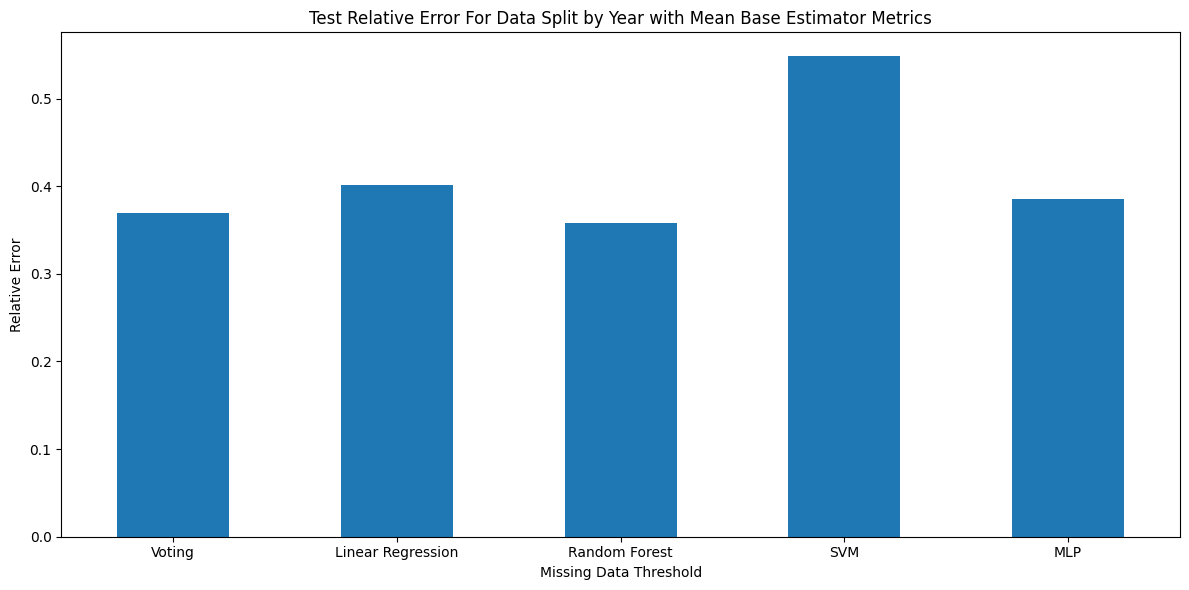

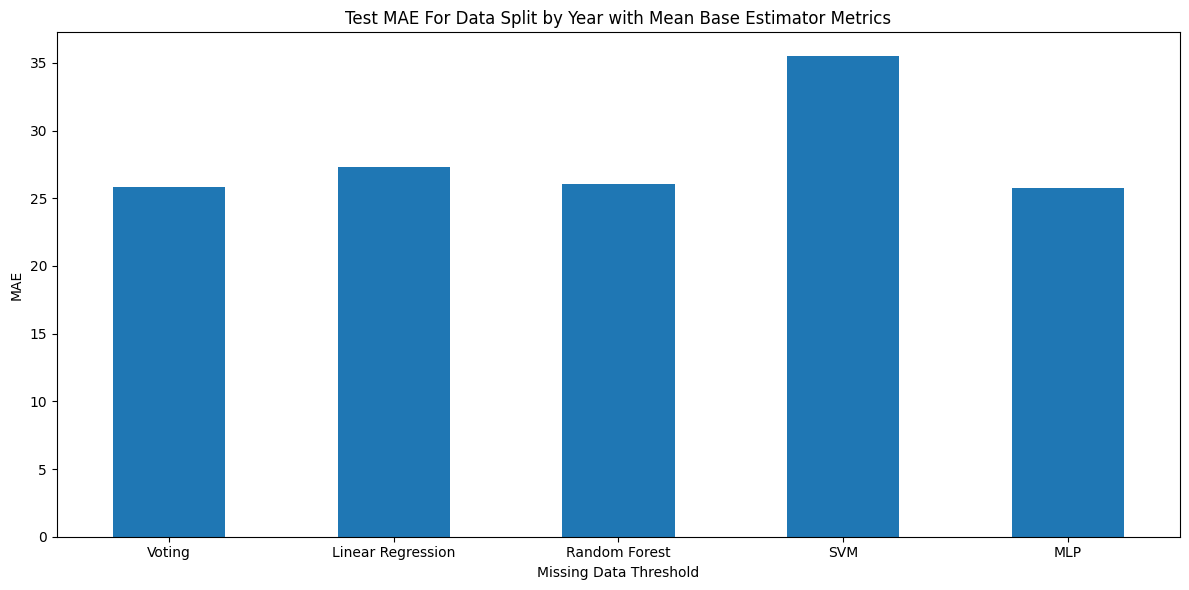

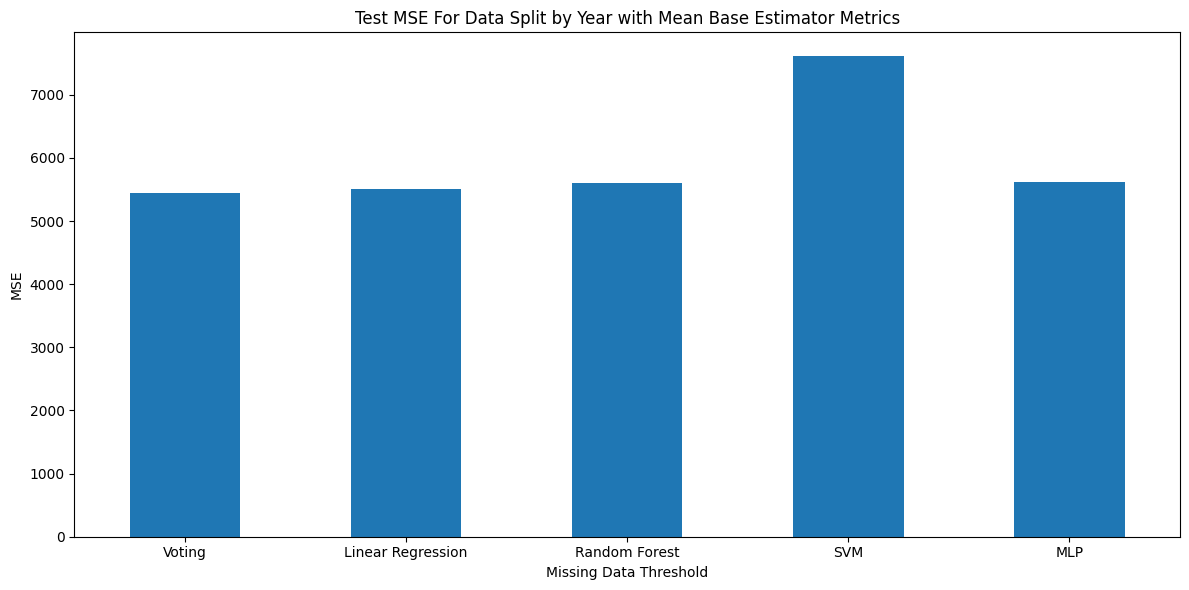

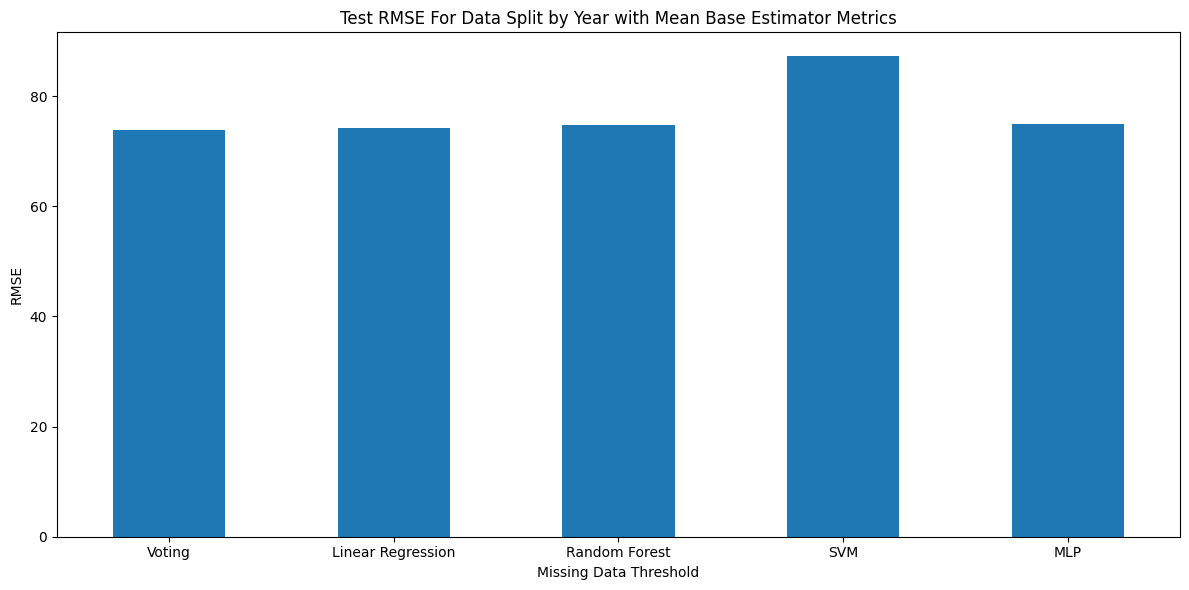

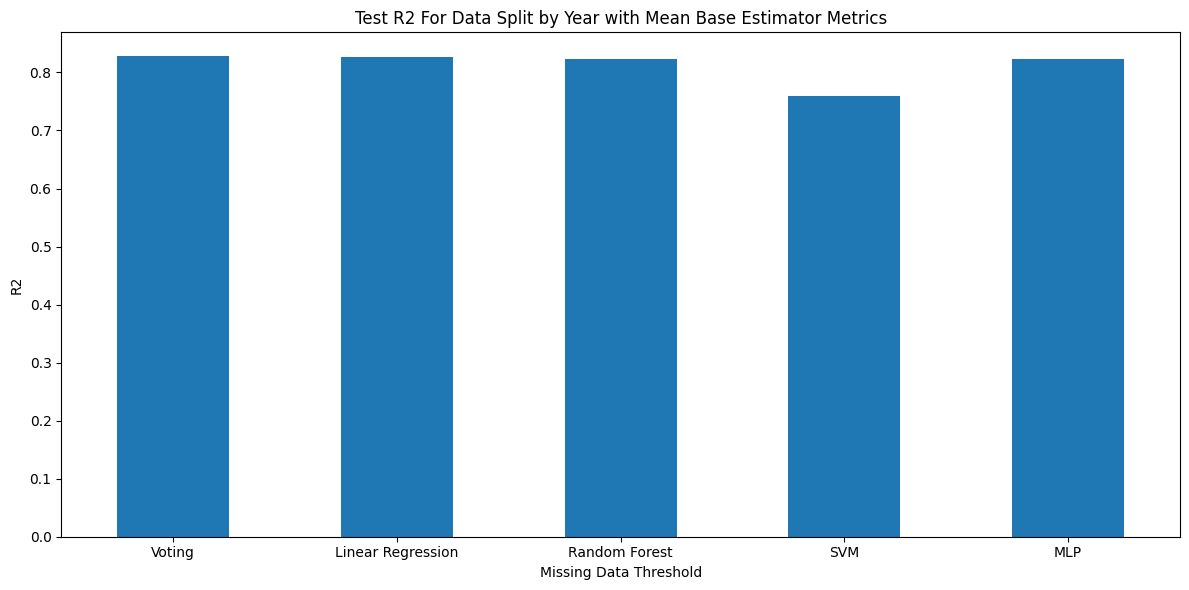

In [80]:
metrics = ['Relative Error', 'MAE', "MSE", 'RMSE', "R2"]
bar_index = ['Voting', 'Linear Regression', 'Random Forest', 'SVM', 'MLP']

for metric in metrics:
    data_metric = test_stats[metric]
    ax = data_metric.plot.bar(rot=0, figsize=(12, 6))     
    plt.title("Test " + metric + " For Data Split by Year with Mean Base Estimator Metrics")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()